# Model comparison

We start our model comparison journey by exploring model overfitting and underfitting and framing good models as ones that are simultaneously able to fit the data (don’t underfit) and make good predictions (don’t overfit).

## Prep plan

* The McElreath reading should take ~1 hour. Spend the rest of your time on this workbook.
* Most of this workbook contains a Python translation of the R code in McElreath, so you can run and read the code here as you read through the text.
* There is 1 question to answer and 1 PyMC exercise to complete in this workbook. The PyMC exercise will require significant time to complete.

## Required reading: Statistical rethinking

Read Chapter 7 up to the end of Section 7.1 of McElreath, R. (2020). _Statistical Rethinking, Second Edition_. Chapman and Hall/CRC Press.

* [Publisher's page](https://www.routledge.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) for buying the book if you want to
* [The whole book is available online on O'Reilly via the San Francisco Public Library](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/15_Chapter07.xhtml). Log in with your library card number.

Outline:

* **The chapter introduction (_Ulysses’ compass_) is required** (1350 words). Much has been written on the topic of model comparison and this introduction gets you ready to think about the goal as striking a balance between models that overfit and models that underfit the data. Note: This chapter makes a few passing references to the previous two chapters which we do not cover in this course. It is okay to ignore the details of those references. (Chapters 5 and 6 deal with Causal Inference which is beyond the scope of CS146 — you should very seriously consider taking CS130 to learn about this important topic.)
* **Section 7.1 (_The problem with parameters_) is required** (3400 words). This section starts by demonstrating the overfitting problem using polynomial regression. This is a very standard way of demonstrating overfitting and you should read the section carefully to become familiar with it. (It’s also a standard way of demonstrating why polynomial regression is usually not a good idea.)

The next part of this pre-class workbook contains the R code provided in the McElreath book, translated to Python and PyMC. The code was modified and cleaned up slightly from [the source](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_07.ipynb) (the `pymc-resources` repository). While reading Section 7.1, you need to follow along in this workbook and run the code as you go. **There are also some questions for you to answer.**

In class, we explore polynomial fitting in more depth and explore the impact of priors on model evidence.

### Code from Section 7.1

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [2]:
# Set the default credible interval to match the textbook
az.rcParams["stats.ci_prob"] = 0.89

#### Code 7.1: Create data

In [3]:
brains = pd.DataFrame.from_dict({
    "species": [
        "afarensis",
        "africanus",
        "habilis",
        "boisei",
        "rudolfensis",
        "ergaster",
        "sapiens"],
    "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
    "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]})  # mass in kg

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


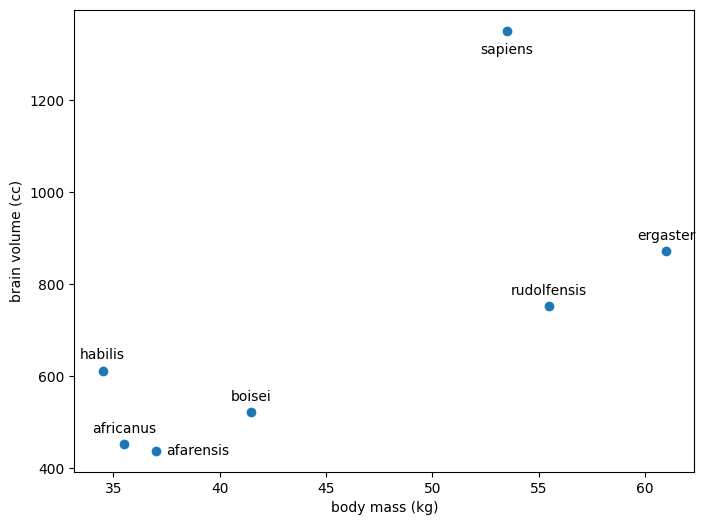

In [4]:
# Figure 7.2

plt.figure(figsize=(8, 6))
plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")

plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)");

#### Code 7.2: Standardize data

In [5]:
brains.loc[:, "mass_std"] = (
    (brains.loc[:, "mass"] - brains.loc[:, "mass"].mean()) /
    brains.loc[:, "mass"].std())
brains.loc[:, "brain_std"] = (
    brains.loc[:, "brain"] / brains.loc[:, "brain"].max())

brains

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


#### Code 7.3: Fit the model

In [6]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=brains).fit()
m_7_1.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Wed, 08 Oct 2025   Prob (F-statistic):             0.0798
Time:                        12:57:58   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Code 7.4: Ordinary least squares fit

In [7]:
p, cov = np.polyfit(
    brains.loc[:, "mass_std"],
    brains.loc[:, "brain_std"],
    1, cov=True)
post = stats.multivariate_normal(p, cov).rvs(1000)
az.summary({k: v for k, v in zip("ba", post.T)}, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.529,0.071,0.414,0.638
b,0.170,0.077,0.041,0.282


#### Code 7.5: Compute $R^2$

In [8]:
1 - m_7_1.resid.var() / brains.brain_std.var()

0.490158047949084

#### Code 7.6: Make $R^2$ function

In [9]:
def R2_is_bad(model):
    return 1 - model.resid.var() / brains.brain_std.var()

R2_is_bad(m_7_1)

0.490158047949084

#### Code 7.7: Fit quadratic model

In [10]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=brains).fit()
m_7_2.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     2.310
Date:                Wed, 08 Oct 2025   Prob (F-statistic):              0.215
Time:                        12:57:59   Log-Likelihood:                 3.3223
No. Observations:                   7   AIC:                           -0.6445
Df Residuals:                       4   BIC:                           -0.8068
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6142      0.155      3.950      0.017       0.182       1.046
mass_std             0.1957      0.093      2.101      0.104      -0.063       0.454
I(mass_std ** 2)    -0.0998      0.159     -0.629      0.564      -0.540       0.341
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.479
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.016
Skew:                           0.901   Prob(JB):                        0.602
Kurtosis:                       2.514   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Code 7.8: Fit degree 3–5 models

In [11]:
m_7_3 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)",
    data=brains).fit()
m_7_4 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=brains,
).fit()
m_7_5 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)"
    " + I(mass_std**5)",
    data=brains,
).fit()

#### Code 7.9: Fit degree 6 model

In [12]:
m_7_6 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)"
    " + I(mass_std**5) + I(mass_std**6)",
    data=brains,
).fit()

#### Code 7.10: Plot results

The chapter gives code to produce the first panel of Figure 7.3. Here, produce the entire figure by looping over models 7.1-7.6.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


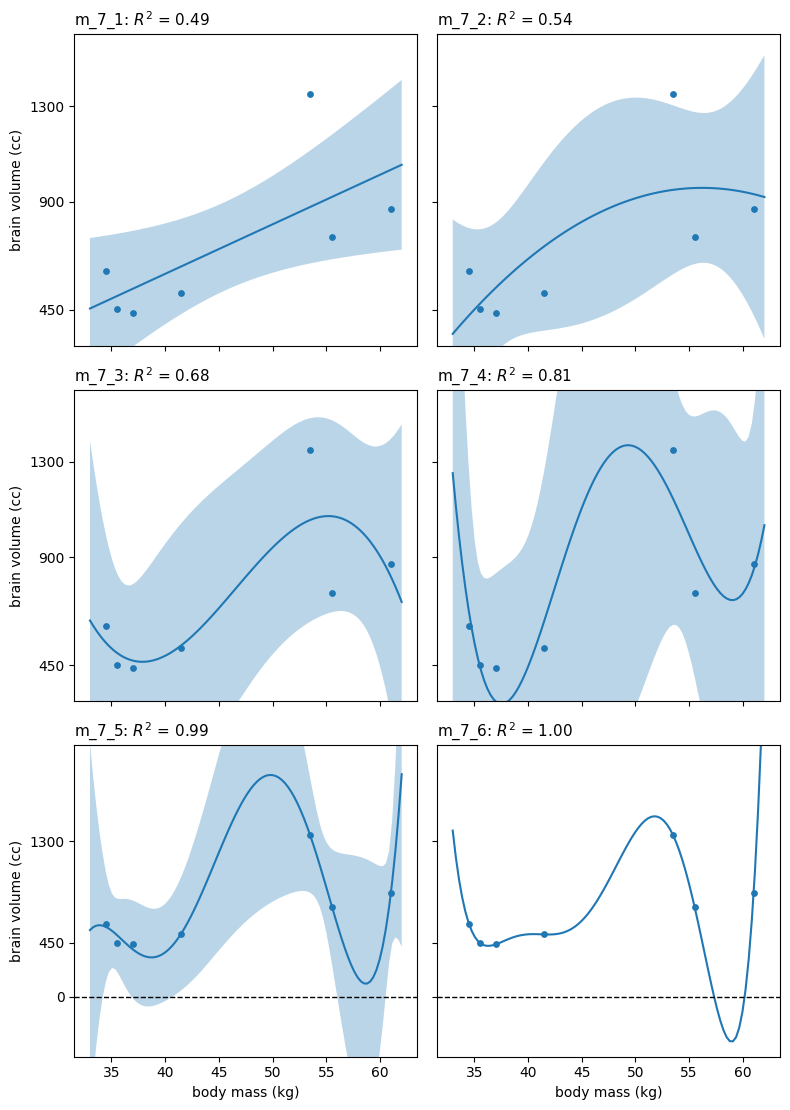

In [13]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

fig, axs = plt.subplots(3, 2, figsize=[8, 11.2], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(
        mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(brains.mass, brains.brain, color="C0", s=15)

    ax.set_title(
        f"{name}: $R^2$ = {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("body mass (kg)")

    if ax.get_subplotspec().is_last_row():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

fig.tight_layout()

#### Code 7.11 This is R-specific notation for dropping rows

In [14]:
brains_new = brains.drop(brains.index[-1])

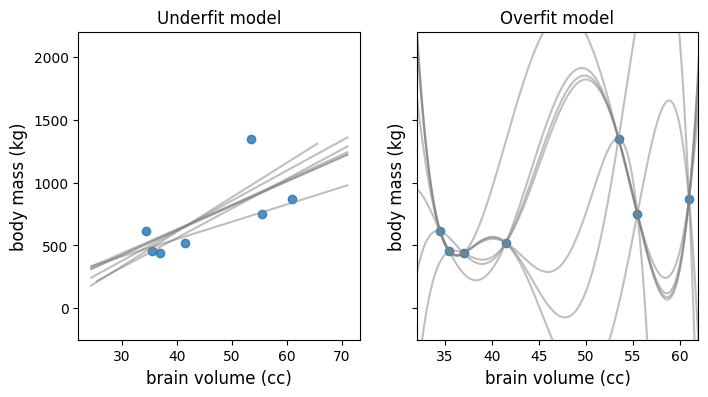

In [15]:
# Figure 7.4

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax1.scatter(brains.mass, brains.brain, alpha=0.8)
ax2.scatter(brains.mass, brains.brain, alpha=0.8)
for i in range(len(brains)):
    d_new = brains.drop(brains.index[-i])  # drop each data point in turn

    # first order model
    m0 = smf.ols("brain ~ mass", d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax1.set_ylabel("body mass (kg)", fontsize=12)
    ax1.set_xlabel("brain volume (cc)", fontsize=12)
    ax1.set_title("Underfit model")

    # fifth order model
    m1 = smf.ols(
        "brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d_new
    ).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 200)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax2.set_xlim(32, 62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel("body mass (kg)", fontsize=12)
    ax2.set_xlabel("brain volume (cc)", fontsize=12)
    ax2.set_title("Overfit model")

Of the 7 straight lines in the left-hand figure above, there is one line that is quite different from the other six lines. Which data point was dropped to generate that one line? Explain.

In [16]:
# ENTER YOUR ANSWER IN YOUR FORUM PRE-CLASS WORKBOOK

## Required task

Implement the polynomial regression model from this chapter in PyMC and run it for different degrees on the same data set to produce a plot similar to Figure 7.3.

We will reuse this model in class.

For a given degree, $d$, and data set $(x_j, y_j)$ the model is

$$\begin{aligned}
\sigma &\sim \text{Log-Normal}(0, 1) \\
\alpha &\sim \text{Normal}(0.5, 1^2) \\
\beta_i &\sim \text{Normal}(0, 10^2) \text{ for } i = 1,2,\ldots,d\\
\mu_j &= \alpha + \sum_{i=1}^d \beta_i (x_j)^i \\
y_j &\sim \text{Normal}(\mu_j, \sigma)
\end{aligned}$$


In [41]:
import pymc as pm

# Fit the polynomial model for degrees 1–6
with pm.Model() as model_1:
  a = pm.Normal("a", mu = 0, sigma = 1)
  b = pm.Normal("b", mu = 0, sigma = 10, shape = 1)
  sigma = pm.Lognormal("sigma", mu = 0, sigma = 1)
  mu = pm.Deterministic("mu", a + b[0] * brains.mass_std)
  y = pm.Normal("y", mu = mu, sigma = sigma, observed = brains.brain_std)

with pm.Model() as model_2:
  a = pm.Normal("a", mu = 0, sigma = 1)
  b = pm.Normal("b", mu = 0, sigma = 10, shape = 2)
  sigma = pm.Lognormal("sigma", mu = 0, sigma = 1)
  mu = pm.Deterministic("mu", a + b[0] * brains.mass_std
                        + b[1] * brains.mass_std ** 2)
  y = pm.Normal("y", mu = mu, sigma = sigma, observed = brains.brain_std)

with pm.Model() as model_3:
  a = pm.Normal("a", mu = 0, sigma = 1)
  b = pm.Normal("b", mu = 0, sigma = 10, shape = 3)
  sigma = pm.Lognormal("sigma", mu = 0, sigma = 1)
  mu = pm.Deterministic("mu", a + b[0] * brains.mass_std
                        + b[1] * brains.mass_std ** 2
                        + b[2] * brains.mass_std ** 3)
  y = pm.Normal("y", mu = mu, sigma = sigma, observed = brains.brain_std)

with pm.Model() as model_4:
  a = pm.Normal("a", mu = 0, sigma = 1)
  b = pm.Normal("b", mu = 0, sigma = 10, shape = 4)
  sigma = pm.Lognormal("sigma", mu = 0, sigma = 1)
  mu = pm.Deterministic("mu", a + b[0] * brains.mass_std
                        + b[1] * brains.mass_std ** 2
                        + b[2] * brains.mass_std ** 3
                        + b[3] * brains.mass_std ** 4)
  y = pm.Normal("y", mu = mu, sigma = sigma, observed = brains.brain_std)


with pm.Model() as model_5:
  a = pm.Normal("a", mu = 0, sigma = 1)
  b = pm.Normal("b", mu = 0, sigma = 10, shape = 5)
  sigma = pm.Lognormal("sigma", mu = 0, sigma = 1)
  mu = pm.Deterministic("mu", a + b[0] * brains.mass_std
                        + b[1] * brains.mass_std ** 2
                        + b[2] * brains.mass_std ** 3
                        + b[3] * brains.mass_std ** 4
                        + b[4] * brains.mass_std ** 5)
  y = pm.Normal("y", mu = mu, sigma = sigma, observed = brains.brain_std)


with pm.Model() as model_6:
  a = pm.Normal("a", mu = 0, sigma = 1)
  b = pm.Normal("b", mu = 0, sigma = 10, shape = 6)
  sigma = 0.001
  mu = pm.Deterministic("mu", a + b[0] * brains.mass_std
                        + b[1] * brains.mass_std ** 2
                        + b[2] * brains.mass_std ** 3
                        + b[3] * brains.mass_std ** 4
                        + b[4] * brains.mass_std ** 5
                        + b[5] * brains.mass_std ** 6)
  y = pm.Normal("y", mu = mu, sigma = sigma, observed = brains.brain_std)

# Plot the results from all 6 model fits




In [ ]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# sample from the six models
traces = []
for model in [model_1, model_2, model_3, model_4, model_5, model_6]:
    with model:
        trace = pm.sample(1000, tune=1000, target_accept=0.9, progressbar=True)
        traces.append(trace)

# convert back to the original scale
x_std = np.linspace(brains.mass_std.min(), brains.mass_std.max(), 100)
mass_mean, mass_std = brains.mass.mean(), brains.mass.std()
brain_max = brains.brain.max()
x = x_std * mass_std + mass_mean

# individual plots
for d, (model, trace) in enumerate(zip(
    [model_1, model_2, model_3, model_4, model_5, model_6], traces), 1):

    # posterior samples
    a_samples = trace.posterior["a"].values.flatten()
    b_samples = trace.posterior["b"].values

    # posterior predictive samples
    mu_pred_std = np.zeros((len(a_samples), len(x_std))) # empty matrix
    for i in range(len(a_samples)): # for each sample
        mu_pred_std[i] = a_samples[i] + sum( # create new data based on the posterior samples
            b_samples[..., j].flatten()[i] * x_std ** (j + 1)
            for j in range(d)
        )

    # convert back to original scale
    mu_pred = mu_pred_std * brain_max

    #plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(brains.mass, brains.brain, c="darkorange", alpha=0.9, label="Observed data")
    az.plot_hdi(x, mu_pred, color="C1")
    plt.plot(x, mu_pred.mean(axis=0), color="C1", label=f"Mean fit (degree {d})")
    plt.xlabel("Mass (original scale)")
    plt.ylabel("Brain (original scale)")
    plt.title(f"Bayesian Polynomial Fit (Degree {d})")
    plt.legend()
    plt.tight_layout()
    plt.show()


Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

ERROR:pymc.stats.convergence:There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()